In [54]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score
import pandas as pd

In [33]:
from google.colab import files
files.upload()  # загрузка kaggle.json

Saving kaggle.json to kaggle (5).json


{'kaggle (5).json': b'{"username":"yuliyagorodnaya","key":"94da6fb20ef621f7af820c124fc3d934"}'}

In [39]:
import os, shutil

# Находим последний скачанный kaggle*.json
json_files = [f for f in os.listdir() if f.startswith("kaggle") and f.endswith(".json")]
json_files.sort(key=lambda x: os.path.getmtime(x), reverse=True)
latest = json_files[0]
print("Используем файл:", latest)

# Kaggle API
!mkdir -p ~/.kaggle
shutil.copy(latest, "/root/.kaggle/kaggle.json")
!chmod 600 ~/.kaggle/kaggle.json

# Скачиваем и распаковываем датасет
!pip install -q kaggle
!kaggle datasets download -d imbikramsaha/food11
!unzip -q food11.zip -d /content/food11

# Проверяем структуру
print("Содержимое /content/food11:")
!ls /content/food11

Используем файл: kaggle (5).json
Dataset URL: https://www.kaggle.com/datasets/imbikramsaha/food11
License(s): CC0-1.0
 99% 515M/519M [00:01<00:00, 303MB/s]
100% 519M/519M [00:01<00:00, 361MB/s]
Содержимое /content/food11:
food11


In [40]:
# Задаём пути, где лежат папки с тренировочными и тестовыми данными
DATA_DIR = '/content/food11/food11'
TRAIN_DIR = os.path.join(DATA_DIR, 'train')
TEST_DIR = os.path.join(DATA_DIR, 'test')

In [55]:
def get_loaders(input_size, batch_size=32):
  # Приводим изображение к нужному размеру, преобразуем в тензор и нормализуем
    transform = transforms.Compose([
        transforms.Resize((input_size, input_size)),
        transforms.ToTensor(),
        transforms.Normalize([0.5]*3, [0.5]*3)
    ])
    full_train = datasets.ImageFolder(TRAIN_DIR, transform=transform)
    class_names = full_train.classes  # Получаем классы ДО split

    train_size = int(0.8 * len(full_train))
    val_size = len(full_train) - train_size
    train_set, val_set = random_split(full_train, [train_size, val_size],
                                      generator=torch.Generator().manual_seed(42))

    test_set = datasets.ImageFolder(TEST_DIR, transform=transform)

    return (
        DataLoader(train_set, batch_size=batch_size, shuffle=True),
        DataLoader(val_set, batch_size=batch_size),
        DataLoader(test_set, batch_size=batch_size),
        class_names  # Возвращаем отдельно все три выборки и метки классов
    )

In [56]:
# EfficientNet (загружаем веса предобученной сети и изменяем на нужный для нашей задачи классификатор)
def get_efficientnet(version, num_classes):
    model_fn = getattr(models, f"efficientnet_{version}") # выберем модель с нужной версией (b0, b1, b2)
    model = model_fn(weights="IMAGENET1K_V1")
    model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
    return model

In [57]:
def train_model(model, train_loader, val_loader, epochs=5):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Используем устройство:", device)
    model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    train_losses, val_accuracies = [], []

    for epoch in range(epochs):
        print(f"\nEpoch {epoch+1}/{epochs}")
        model.train()
        total_loss = 0
        for i, (x, y) in enumerate(train_loader):
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            outputs = model(x)
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

            if i % 10 == 0:
                print(f"   Batch {i}/{len(train_loader)} — Loss: {loss.item():.4f}")

        avg_loss = total_loss / len(train_loader)
        train_losses.append(avg_loss)

        # Валидация
        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(device), y.to(device)
                preds = model(x).argmax(1)
                correct += (preds == y).sum().item()
                total += y.size(0)
        val_acc = correct / total
        val_accuracies.append(val_acc)

        print(f" Epoch {epoch+1} завершена — Train Loss: {avg_loss:.4f}, Val Accuracy: {val_acc*100:.2f}%")

    return model, train_losses, val_accuracies

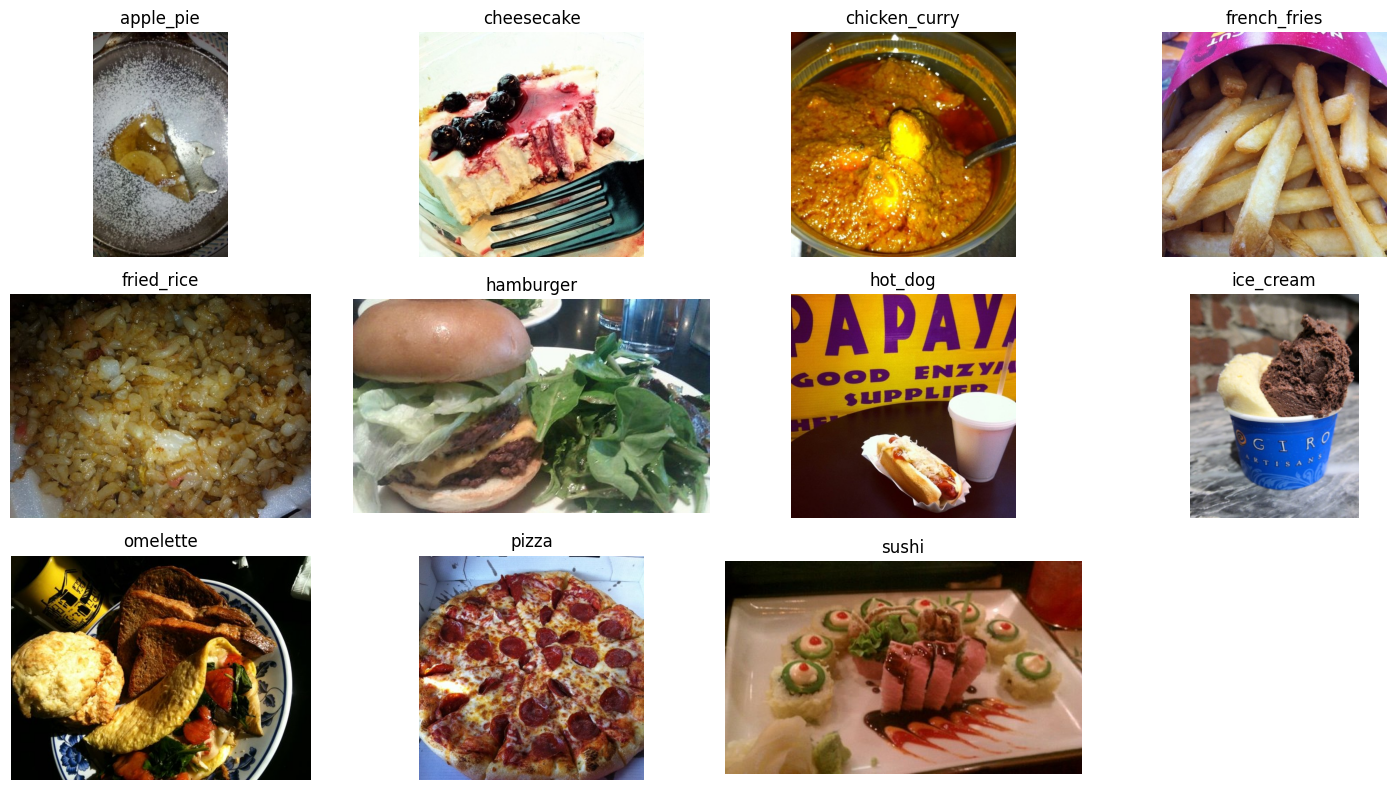

In [58]:
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from PIL import Image
import os

# Путь к обучающей выборке
TRAIN_DIR = '/content/food11/food11/train'

# Трансформации (без нормализации)
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

# Загружаем датасет
dataset = datasets.ImageFolder(TRAIN_DIR, transform=transform)
class_names = dataset.classes

# Собираем по одному изображению на класс
samples = {}
for path, label in dataset.samples:
    class_name = class_names[label]
    if class_name not in samples:
        samples[class_name] = path
    if len(samples) == len(class_names):
        break

# Визуализация
plt.figure(figsize=(15, 8))
for i, (class_name, path) in enumerate(samples.items()):
    img = Image.open(path)
    plt.subplot(3, 4, i+1)
    plt.imshow(img)
    plt.title(class_name)
    plt.axis('off')
plt.tight_layout()
plt.show()


In [60]:
# Обучаем все три модели по пять эпох каждая
input_sizes = {"b0": 224, "b1": 240, "b2": 260}
results = {}
conf_matrices = {}

for version in ["b0", "b1", "b2"]:
    print(f"\n EfficientNet-{version.upper()}")
    input_size = input_sizes[version]
    train_loader, val_loader, test_loader, class_names = get_loaders(input_size)
    model = get_efficientnet(version, num_classes=11)
    model, train_loss, val_acc = train_model(model, train_loader, val_loader)

    # Тест
    y_true, y_pred = [], []
    model.eval()
    with torch.no_grad():
        for x, y in test_loader:
            x = x.to(next(model.parameters()).device)
            preds = model(x).argmax(1).cpu()
            y_true.extend(y.numpy())
            y_pred.extend(preds.numpy())

    acc = accuracy_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)
    results[version] = {"val_acc": val_acc[-1], "test_acc": acc, "train_loss": train_loss, "val_acc_list": val_acc}
    conf_matrices[version] = cm


 EfficientNet-B0
Используем устройство: cuda

Epoch 1/5
   Batch 0/248 — Loss: 2.4416
   Batch 10/248 — Loss: 2.3832
   Batch 20/248 — Loss: 2.2782
   Batch 30/248 — Loss: 2.1328
   Batch 40/248 — Loss: 1.9506
   Batch 50/248 — Loss: 1.8027
   Batch 60/248 — Loss: 1.6352
   Batch 70/248 — Loss: 1.3710
   Batch 80/248 — Loss: 1.2816
   Batch 90/248 — Loss: 1.2666
   Batch 100/248 — Loss: 1.2966
   Batch 110/248 — Loss: 1.0797
   Batch 120/248 — Loss: 0.9068
   Batch 130/248 — Loss: 0.9525
   Batch 140/248 — Loss: 0.8928
   Batch 150/248 — Loss: 0.4855
   Batch 160/248 — Loss: 0.9142
   Batch 170/248 — Loss: 0.7918
   Batch 180/248 — Loss: 0.6818
   Batch 190/248 — Loss: 0.4806
   Batch 200/248 — Loss: 0.8377
   Batch 210/248 — Loss: 0.4531
   Batch 220/248 — Loss: 0.9001
   Batch 230/248 — Loss: 0.8487
   Batch 240/248 — Loss: 0.7259
 Epoch 1 завершена — Train Loss: 1.2257, Val Accuracy: 84.80%

Epoch 2/5
   Batch 0/248 — Loss: 0.5001
   Batch 10/248 — Loss: 0.6699
   Batch 20/248 — Lo

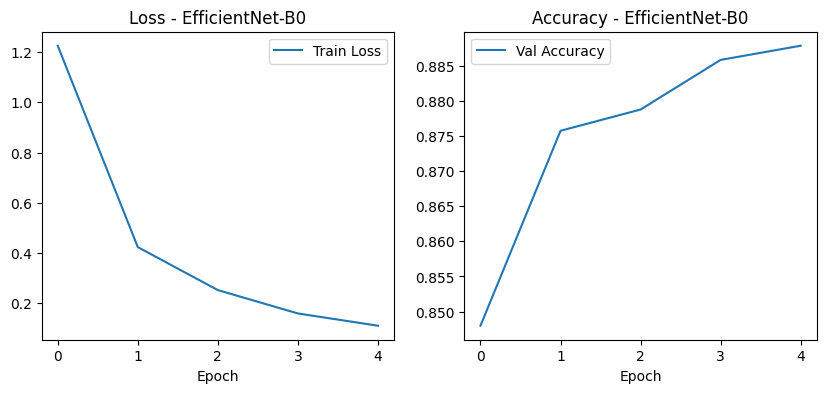

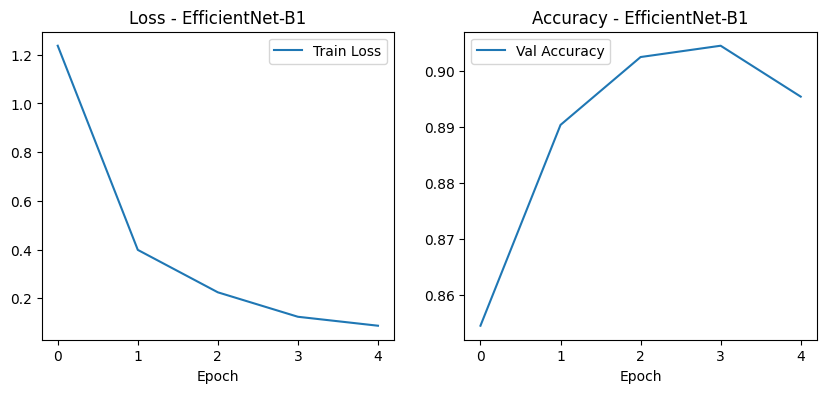

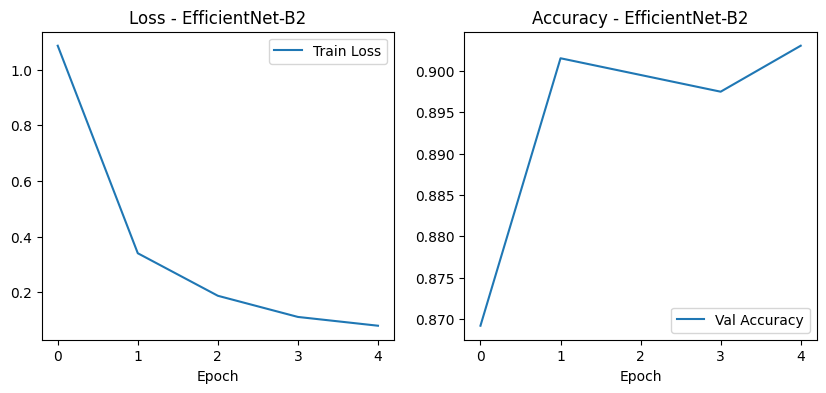

In [61]:
# Графики обучения
for version in results:
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.plot(results[version]["train_loss"], label="Train Loss")
    plt.title(f"Loss - EfficientNet-{version.upper()}")
    plt.xlabel("Epoch")
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(results[version]["val_acc_list"], label="Val Accuracy")
    plt.title(f"Accuracy - EfficientNet-{version.upper()}")
    plt.xlabel("Epoch")
    plt.legend()
    plt.show()

Проанализируем графики обучения:

Как видим, в случае всех трёх моделей loss снижается с количеством эпох, однако невозможно утверждать, что мы достигли минимального значения. Наверняка 5 эпох недостаточно и, возможно, мы могли бы достичь меньшей ошибки, продолжая обучение.

Accuracy: к b0 и b2 вопросов нет, хотя опять же, думаю, что продолжая итерации, мы бы достигли точности получше. График для b1 выглядит, как будто пик качества модели был на третьей эпохе, но вряд ли какой-то модели достаточно трёх эпох для обучения, скорее всего после спада график снова пойдёт вверх.

в целом выглядит адекватно, но определённо надо больше эпох

In [62]:
# Таблица сравнения
df = pd.DataFrame({
    "Model": [f"EfficientNet-{v.upper()}" for v in results],
    "Val Accuracy": [f"{results[v]['val_acc']*100:.2f}%" for v in results],
    "Test Accuracy": [f"{results[v]['test_acc']*100:.2f}%" for v in results]
})
print(df)

             Model Val Accuracy Test Accuracy
0  EfficientNet-B0       88.79%        89.64%
1  EfficientNet-B1       89.55%        90.91%
2  EfficientNet-B2       90.30%        91.64%


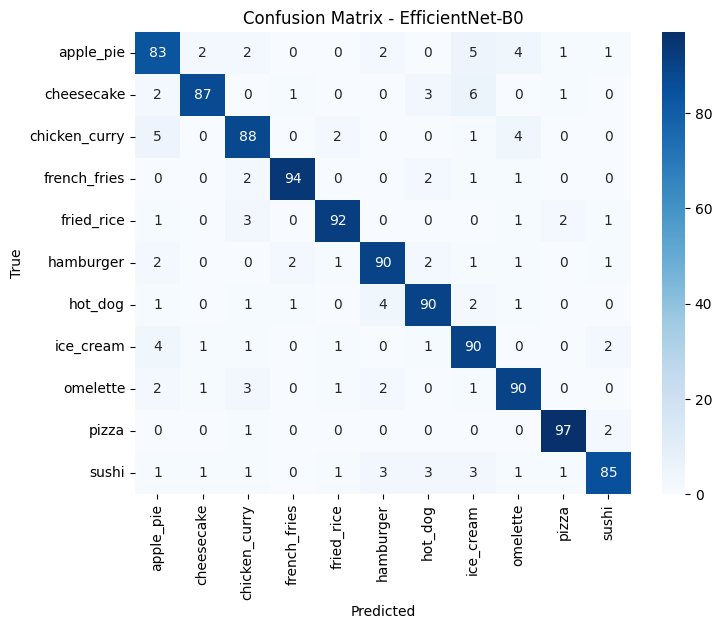

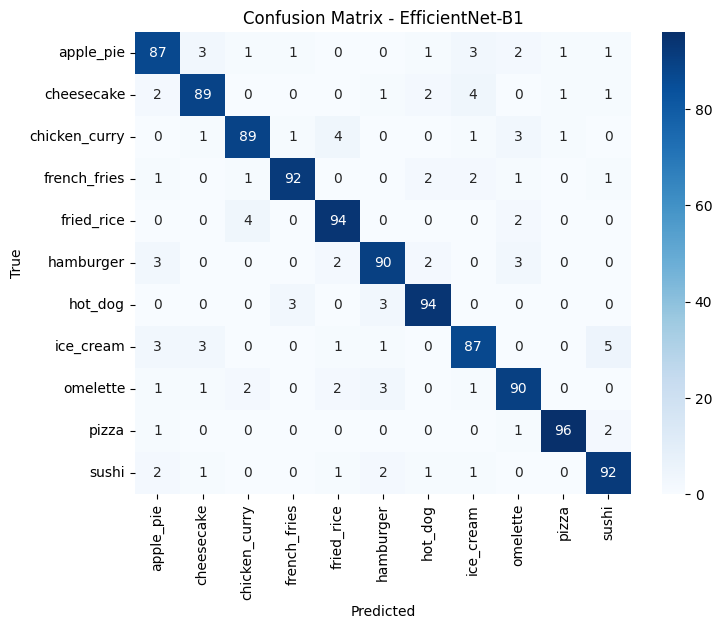

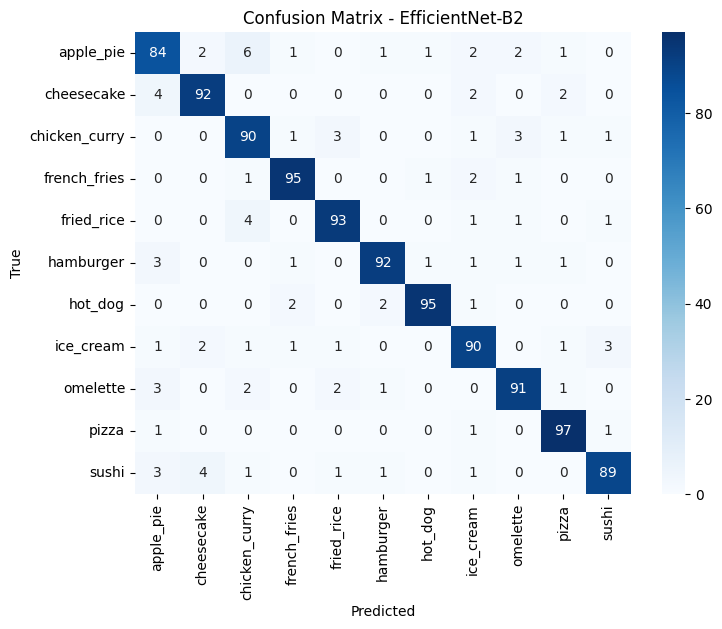

In [63]:
# Матрицы ошибок
for version in conf_matrices:
    plt.figure(figsize=(8,6))
    sns.heatmap(conf_matrices[version], annot=True, fmt="d", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f"Confusion Matrix - EfficientNet-{version.upper()}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()


Теперь проанализируем матрицы ошибок, чтобы понять, какие классы модельки путают чаще всего.

**Efficient-B0.**

apple-pie и cheesecake часто путает с ice-cream

chicken curry с apple pie (как ни странно, на фото действительно много сходств, цветовая гамма как минимум)


**Выделим сильные классы** (модель реже всего ошибается в них):

pizza = 97% accuracy

hot-dog = 94%

fried rice = 92%

**Слабые:**

apple pie (83%)

sushi (85%)

cheesecake (87%)

**Efficient-B1.**

**Сильные классы:**

pizza (96%)

hot-dog (94%)

fried_rice (94%)

**Слабые классы:**

apple pie (87%)

ice cream (87%)


**Efficient-B2.**

**Сильные:**

pizza (97%)

hot dog (95%)

french-fries (95%)

**Слабые:**

apple pie (84%)

sushi (89%)

Итого по всем трем матрицам:

Слабое звено: apple pie, sushi

Сильные классы: french fries, pizza, hot dog (изображения данных классов содержат больше уникальных признаков, которые позволяют точнее их определять, в то время, как на картинках суши действительно чем-то похожи на чизкейк или яблочный пирог).